In [1]:
import tensorflow as tf
import edward as ed
import pandas as pd

import numpy as np
np.set_printoptions(precision=2, suppress=True)

from edward.models import Empirical, Dirichlet, Categorical
from edward.inferences import HMC
import pylab as plt

In [2]:
sess = tf.Session()
ed.set_seed(520)

In [3]:
alpha = tf.placeholder(tf.float32, (2, ))
theta = Dirichlet(alpha)
z = Categorical(theta)

## The Dirichlet distribution

In [18]:
with sess.as_default():
    print(theta.sample(3).eval(feed_dict={alpha:[1,1]}))

[[0.7  0.3 ]
 [0.3  0.7 ]
 [0.02 0.98]]


The sum of the dirichlet parameters determines the concentration of the sampled distributions. Higher parameters lead to a higher concentration meaning that probabilities for each category are more similar.

In [19]:
concentration_test = [[0.01,0.01], [1,1],[100,100]]

In [20]:
concentration_list = list()
with sess.as_default():
    for alpha_temp in concentration_test: 
        temp = theta.sample(100).eval(feed_dict={alpha:alpha_temp})
        concentration_list.append(temp[:,0]) # Plot the probability of the first category

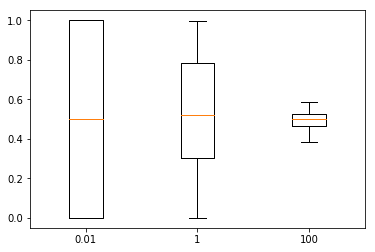

In [21]:
plt.boxplot(concentration_list, labels = ["0.01","1","100"],)
plt.show()

You see the variance of the probability of the first class. Increasing absolute size of the Dirichlet parameters in $[0,\inf]$ decreases the concentration of the distribution on only few classes. In other words, for high parameter values, the two class probabilites fall closer to 0.5.

In [8]:
asymmetric_test = [[0.02,0.01], [2,1],[200,100]]

In [9]:
asymmetric_list = list()
with sess.as_default():
    for alpha_temp in asymmetric_test: 
        temp = theta.sample(100).eval(feed_dict={alpha:alpha_temp})
        asymmetric_list.append(temp[:,0])

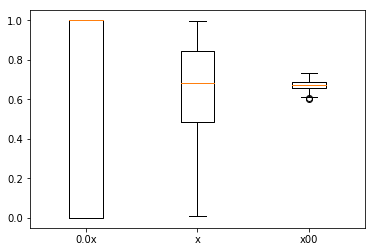

In [10]:
plt.boxplot(asymmetric_list, labels = ["0.0x","x","x00"],)
plt.show()

You see the variance of the probability of the first class. The relative higher size of the Dirichlet parameters in $[0,\inf]$ increases the probability of the first class.

## Simulation

### One customer - one set of product preferences

In [22]:
n_customers = 1
n_products = 5
n_purchases = 50

In [23]:
preferences = np.array([0.4,0.05,0.05,0.1,0.4])
baskets = np.zeros([n_customers,n_purchases], dtype="int")

In [24]:
with sess.as_default():
    baskets = Categorical(probs=preferences).sample(n_purchases).eval()

In [25]:
baskets

array([4, 0, 0, 4, 0, 4, 3, 0, 4, 4, 4, 0, 0, 3, 4, 0, 0, 4, 0, 0, 0, 0,
       0, 4, 2, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 3, 0, 4,
       0, 4, 0, 0, 0, 4], dtype=int32)

I only estimate the normal distribution (read "product preferences") for one customer, because Edward has issues with working on all customers in bulk. The reason is that we "select" the personal normal distribution for each customer with tf.gather() and Edward has trouble automatizing inference on variables extracted with tf.gather(). The reason for that is that gather() returns a tensor and not an Edward random variable class. 

In [26]:
alpha = 0.2*tf.ones(n_products)
theta = Dirichlet(alpha)
x = Categorical(probs = theta, sample_shape=n_purchases)

In [27]:
qtheta = Empirical(tf.get_variable(
    "qtheta/params", 
    [1000, n_products], # 1000 samples
    initializer=tf.constant_initializer(1.0 / n_products)))

In [28]:
inference = ed.Gibbs({theta: qtheta}, data={x: baskets})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [29]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 1.000


In [30]:
preferences # True preferences

array([0.4 , 0.05, 0.05, 0.1 , 0.4 ])

In [31]:
np.array(pd.Series(baskets).value_counts().sort_index()/n_purchases) # Naive estimate

array([0.5 , 0.02, 0.06, 0.42])

In [39]:
np.mean(qtheta.sample(5000).eval(), axis = 0) # Our model (mean) estimate

array([0.5 , 0.  , 0.02, 0.06, 0.41], dtype=float32)

### One customer - several motivations - one set of product preferences per motivation

Why would we do this? Estimating product preferences for each customer requires a lot of information for each customer. For a customer, we observe purchases only over a very small set of products. Here's the trick: We estimate customer preferences for a small set of motivations, e.g. 20 motivations instead of 10000 products. We also estimate product preferences for each motivation *using the purchases of all customers*. 

In marketing intuition: We estimate product preferences for 20 segments of customers and in the same model we estimate the fuzzy/soft segment each customer belongs to. 

In [119]:
tf.reset_default_graph()

In [120]:
n_customers = 10
n_products = 5
n_purchases = 50

n_motivations = 10  # number of motivations

In [121]:
preferences = np.zeros([n_customers,n_products])
with tf.Session() as sess:
    for c in range(n_customers):
        preferences[c,:] = Dirichlet(tf.ones(n_products)).sample().eval()

In [122]:
baskets = np.zeros([n_customers, n_purchases], dtype="int")
with tf.Session() as sess:
    for c in range(n_customers):
        baskets[c,:] = Categorical(probs=preferences[c,:]).sample(n_purchases).eval()

In [123]:
for c in range(n_customers):
    print(baskets[c][0:5])

[0 2 0 1 0]
[3 3 0 4 4]
[4 4 1 4 1]
[4 4 4 1 0]
[0 1 0 1 2]
[0 0 1 3 1]
[4 4 0 4 4]
[2 0 2 2 0]
[0 2 0 0 1]
[1 2 1 3 2]


In [124]:
alpha = tf.zeros([n_customers, n_motivations]) + 0.2
theta = Dirichlet(alpha)

beta = tf.zeros([n_motivations, n_products]) + 0.05
phi = Dirichlet(beta)

theta_set = [[None]*n_purchases]*n_customers
for c in range(n_customers):
    for n in range(n_purchases):
        theta_set[c][n] = tf.gather(theta,c)
theta_set = tf.Variable(theta_set)

z = Categorical(theta_set ) # z～P(z|theta)
x = Categorical(tf.gather(phi,z) ) # w ～P(w|z)


In [125]:
qtheta = Empirical(tf.get_variable(
    "qtheta/params", [1000, n_products],
    initializer=tf.constant_initializer(1.0 / n_products)))
qphi = Empirical(tf.get_variable(
    "qphi/params", [1000, n_products],
    initializer=tf.constant_initializer(1.0 / n_products)))
qz = Empirical(tf.get_variable(
    "qz/params", [1000, n_products],
    initializer=tf.constant_initializer(1.0 / n_products)))

In [126]:
inference = ed.Gibbs({theta: qtheta, phi:qphi, z:qz}, data={x: baskets})

AttributeError: 'NoneType' object has no attribute 'shape'

In [28]:
inference.run()

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 1.001
